In [1]:
import copy
import collections
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolAlign
from rdkit.Chem import PeriodicTable
from rdkit.Chem.Lipinski import RotatableBondSmarts
import scipy
from scipy import spatial as sci_spatial
import torch
from tqdm.auto import tqdm
from collections import Counter
import seaborn as sns

ptable = Chem.GetPeriodicTable()

In [2]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  

In [3]:
import sys, os
sys.path.insert(0, os.path.abspath('../'))

from utils.evaluation import eval_bond_length, scoring_func, similarity

In [4]:
MODEL_NAME = 'KGDiff'

# Load Data

In [5]:
class Globals:
    reference_path = 'benchmark/crossdocked_test_vina_docked.pt'
    cvae_path = 'benchmark/CVAE_test_docked_sf1.5.pt'
    ar_path = 'benchmark/ar_vina_docked.pt'
    pocket2mol_path = 'benchmark/pocket2mol_vina_docked.pt'
    targetdiff_path = 'benchmark/targetdiff_vina_docked.pt'    
    rep_targetdiff_path = 'benchmark/repeat_targetdiff.pt'    
    joint_pv_baseline_vina_path = 'benchmark/joint_pv_baseline_vina.pt'    
    joint_pv_type100_vina_path = 'benchmark/joint_pv_type100_full_vina.pt'    
    joint_pv_pos25_vina_path = 'benchmark/joint_pv_pos25_full_vina.pt'    
    targetdiff_valuenet_path = 'benchmark/targetdiff_valuenet_docked.pt'    
    our_path = 'benchmark/our_vina_score_docked.pt'
    our_path_full_feature = 'benchmark/our_vina_score_docked_full_feature.pt'
    pdbbind_random_type100_pos5_path = 'benchmark/pdbbind_random_guide_pos5_type100_wo_vina.pt'
    pdbbind_random_baseline_path = 'benchmark/pdbbind_random_baseline_wo_vina.pt'

In [6]:
Globals.reference_results = torch.load(Globals.reference_path)
Globals.reference_results = [[v] for v in Globals.reference_results]
Globals.ar_results = torch.load(Globals.ar_path)
Globals.pocket2mol_results = torch.load(Globals.pocket2mol_path)
Globals.cvae_results = torch.load(Globals.cvae_path)
Globals.targetdiff_results = torch.load(Globals.targetdiff_path)
Globals.our_results = torch.load(Globals.our_path)
Globals.joint_pv_baseline_vina = torch.load(Globals.joint_pv_baseline_vina_path)
Globals.joint_pv_type100_vina = torch.load(Globals.joint_pv_type100_vina_path)
Globals.joint_pv_pos25_vina = torch.load(Globals.joint_pv_pos25_vina_path)
Globals.targetdiff_valuenet_vina = torch.load(Globals.targetdiff_valuenet_path)

Globals.our_results_full_feature = torch.load(Globals.our_path_full_feature)
Globals.rep_targetdiff = torch.load(Globals.rep_targetdiff_path)
Globals.pdbbind_random_type100_pos5 = torch.load(Globals.pdbbind_random_type100_pos5_path)
Globals.pdbbind_random_baseline = torch.load(Globals.pdbbind_random_baseline_path)


# Metrics Summary

In [10]:
def print_ring(ring_size):
    ring_res=[]
    for i in range(3,10):
        if i in ring_size:
            ring_res.append(ring_size[i])
        else:
            ring_res.append(0)
    ring_res = np.array(ring_res) / np.sum(ring_res)
    for i in range(3,10):
        print('%d ring | %.2f%%' % (i, ring_res[i-3]*100))
    
def print_results(results, show_vina=True):
    qed = [r['chem_results']['qed'] for r in results]
    sa = [r['chem_results']['sa'] for r in results]
    mol_size = [r['mol'].GetNumAtoms() for r in results]
    ring_size = Counter({})
    for r in results:
        ring_size.update(r['chem_results']['ring_size'])
    print_ring(ring_size)
    print('Num results: %d' % len(results))
    if show_vina:
        vina_score_only = [x['vina']['score_only'][0]['affinity'] for x in results]
        vina_min = [x['vina']['minimize'][0]['affinity'] for x in results]
        vina_dock = [r['vina']['dock'][0]['affinity'] for r in results]
        print('[Vina Score] Avg: %.2f | Med: %.2f' % (np.mean(vina_score_only), np.median(vina_score_only)))
        print('[Vina Min]   Avg: %.2f | Med: %.2f' % (np.mean(vina_min), np.median(vina_min)))
        print('[Vina Dock]  Avg: %.2f | Med: %.2f' % (np.mean(vina_dock), np.median(vina_dock)))
        
    print('[QED]  Avg: %.4f | Med: %.4f' % (np.mean(qed), np.median(qed)))
    print('[SA]   Avg: %.4f | Med: %.4f' % (np.mean(sa), np.median(sa)))
    print('[Size] Avg: %.4f | Med: %.4f' % (np.mean(mol_size), np.median(mol_size)))

def compute_high_affinity(vina_ref, results):
    percentage_good = []
    num_docked = []
    qed_good, sa_good = [], []
    for i in range(100):
        score_ref = vina_ref[i]
        pocket_results = [r for r in results[i] if r['vina'] is not None]
        if len(pocket_results) < 50:
            continue
        num_docked.append(len(pocket_results))

        scores_gen = []
        for docked in pocket_results:
            aff = docked['vina']['dock'][0]['affinity']
            scores_gen.append(aff)
            if aff <= score_ref:
                qed_good.append(docked['chem_results']['qed'])
                sa_good.append(docked['chem_results']['sa'])
        scores_gen = np.array(scores_gen)
        percentage_good.append((scores_gen <= score_ref).mean())

    percentage_good = np.array(percentage_good)
    num_docked = np.array(num_docked)

    print('[HF%%]  Avg: %.2f%% | Med: %.2f%% ' % (np.mean(percentage_good)*100, np.median(percentage_good)*100))
    print('[HF-QED]  Avg: %.4f | Med: %.4f ' % (np.mean(qed_good)*100, np.median(qed_good)*100))
    print('[HF-SA]   Avg: %.4f | Med: %.4f ' % (np.mean(sa_good)*100, np.median(sa_good)*100))
    print('[Success%%] %.2f%% ' % (np.mean(percentage_good > 0)*100, ))

## Reference

In [11]:
flat_ref_docked = [r for pr in Globals.reference_results for r in pr]
print_results(flat_ref_docked)

3 ring | 1.65%
4 ring | 0.00%
5 ring | 30.17%
6 ring | 67.36%
7 ring | 0.83%
8 ring | 0.00%
9 ring | 0.00%
Num results: 100
[Vina Score] Avg: -6.36 | Med: -6.46
[Vina Min]   Avg: -6.71 | Med: -6.49
[Vina Dock]  Avg: -7.45 | Med: -7.26
[QED]  Avg: 0.4760 | Med: 0.4676
[SA]   Avg: 0.7277 | Med: 0.7400
[Size] Avg: 22.7500 | Med: 21.5000


In [12]:
vina_ref = [r['vina']['dock'][0]['affinity'] for r in flat_ref_docked]

## AR

In [13]:
flat_ar_docked = [r for pr in Globals.ar_results for r in pr]
print_results(flat_ar_docked)
compute_high_affinity(vina_ref, Globals.ar_results)

3 ring | 29.60%
4 ring | 0.04%
5 ring | 16.10%
6 ring | 51.44%
7 ring | 1.64%
8 ring | 0.69%
9 ring | 0.49%
Num results: 9295
[Vina Score] Avg: -5.75 | Med: -5.64
[Vina Min]   Avg: -6.18 | Med: -5.88
[Vina Dock]  Avg: -6.75 | Med: -6.62
[QED]  Avg: 0.5089 | Med: 0.4997
[SA]   Avg: 0.6366 | Med: 0.6300
[Size] Avg: 17.6815 | Med: 16.0000
[HF%]  Avg: 37.94% | Med: 31.00% 
[HF-QED]  Avg: 52.1360 | Med: 51.9444 
[HF-SA]   Avg: 59.7250 | Med: 59.0000 
[Success%] 91.58% 


## Pocket2Mol

In [14]:
flat_p2m_docked = [r for pr in Globals.pocket2mol_results for r in pr]
print_results(flat_p2m_docked)
compute_high_affinity(vina_ref, Globals.pocket2mol_results)

3 ring | 0.12%
4 ring | 0.02%
5 ring | 16.38%
6 ring | 80.41%
7 ring | 2.61%
8 ring | 0.35%
9 ring | 0.12%
Num results: 9831
[Vina Score] Avg: -5.14 | Med: -4.70
[Vina Min]   Avg: -6.42 | Med: -5.82
[Vina Dock]  Avg: -7.15 | Med: -6.79
[QED]  Avg: 0.5729 | Med: 0.5770
[SA]   Avg: 0.7558 | Med: 0.7600
[Size] Avg: 17.7363 | Med: 15.0000
[HF%]  Avg: 48.36% | Med: 51.00% 
[HF-QED]  Avg: 56.5935 | Med: 57.5578 
[HF-SA]   Avg: 72.3812 | Med: 72.0000 
[Success%] 88.78% 


## TargetDiff

In [15]:
flat_targetdiff_docked = [r for pr in Globals.targetdiff_results for r in pr]
print_results(flat_targetdiff_docked)
compute_high_affinity(vina_ref, Globals.targetdiff_results)

3 ring | 0.00%
4 ring | 2.79%
5 ring | 30.78%
6 ring | 50.73%
7 ring | 12.13%
8 ring | 2.68%
9 ring | 0.88%
Num results: 9036
[Vina Score] Avg: -5.47 | Med: -6.30
[Vina Min]   Avg: -6.64 | Med: -6.83
[Vina Dock]  Avg: -7.80 | Med: -7.91
[QED]  Avg: 0.4798 | Med: 0.4808
[SA]   Avg: 0.5846 | Med: 0.5800
[Size] Avg: 24.2371 | Med: 24.0000
[HF%]  Avg: 58.11% | Med: 59.09% 
[HF-QED]  Avg: 49.8408 | Med: 49.9754 
[HF-SA]   Avg: 56.3709 | Med: 56.0000 
[Success%] 98.99% 


## TargetDiff repeat

In [16]:
flat_targetdiff_docked_rep = [r for pr in Globals.rep_targetdiff for r in pr]
print_results(flat_targetdiff_docked_rep)
compute_high_affinity(vina_ref, Globals.rep_targetdiff)

3 ring | 0.00%
4 ring | 2.81%
5 ring | 30.53%
6 ring | 51.30%
7 ring | 11.93%
8 ring | 2.59%
9 ring | 0.85%
Num results: 9117
[Vina Score] Avg: -5.50 | Med: -6.32
[Vina Min]   Avg: -6.69 | Med: -6.86
[Vina Dock]  Avg: -7.83 | Med: -7.92
[QED]  Avg: 0.4881 | Med: 0.4914
[SA]   Avg: 0.5858 | Med: 0.5800
[Size] Avg: 24.2686 | Med: 24.0000
[HF%]  Avg: 59.24% | Med: 60.43% 
[HF-QED]  Avg: 50.7348 | Med: 51.1665 
[HF-SA]   Avg: 56.5636 | Med: 56.0000 
[Success%] 100.00% 


## TargetDiff + Valuenet

In [17]:
flat_targetdiff_valuenet_docked = [r for pr in Globals.targetdiff_valuenet_vina for r in pr]
print_results(flat_targetdiff_valuenet_docked)
compute_high_affinity(vina_ref, Globals.targetdiff_valuenet_vina)

3 ring | 0.00%
4 ring | 3.23%
5 ring | 25.35%
6 ring | 45.98%
7 ring | 19.70%
8 ring | 4.83%
9 ring | 0.91%
Num results: 4306
[Vina Score] Avg: -7.50 | Med: -8.16
[Vina Min]   Avg: -8.40 | Med: -8.52
[Vina Dock]  Avg: -9.20 | Med: -9.16
[QED]  Avg: 0.4765 | Med: 0.4775
[SA]   Avg: 0.5561 | Med: 0.5600
[Size] Avg: 24.9712 | Med: 25.0000
[HF%]  Avg: 71.67% | Med: 78.58% 
[HF-QED]  Avg: 49.4985 | Med: 49.9580 
[HF-SA]   Avg: 51.5389 | Med: 52.0000 
[Success%] 100.00% 


## Ours

In [18]:
flat_our_docked = [r for pr in Globals.our_results for r in pr]
print_results(flat_our_docked)
compute_high_affinity(vina_ref, Globals.our_results)

3 ring | 0.00%
4 ring | 2.92%
5 ring | 21.29%
6 ring | 46.02%
7 ring | 21.17%
8 ring | 6.37%
9 ring | 2.23%
Num results: 8813
[Vina Score] Avg: -8.04 | Med: -8.61
[Vina Min]   Avg: -8.78 | Med: -8.85
[Vina Dock]  Avg: -9.43 | Med: -9.43
[QED]  Avg: 0.5070 | Med: 0.5078
[SA]   Avg: 0.5355 | Med: 0.5400
[Size] Avg: 24.5268 | Med: 25.0000
[HF%]  Avg: 79.18% | Med: 86.96% 
[HF-QED]  Avg: 50.9139 | Med: 50.9569 
[HF-SA]   Avg: 50.8336 | Med: 51.0000 
[Success%] 100.00% 


## Ours full feature

In [19]:
flat_our_docked_full = [r for pr in Globals.our_results_full_feature for r in pr]
print_results(flat_our_docked_full)
compute_high_affinity(vina_ref, Globals.our_results_full_feature)

3 ring | 0.00%
4 ring | 1.70%
5 ring | 21.26%
6 ring | 46.44%
7 ring | 22.50%
8 ring | 6.38%
9 ring | 1.73%
Num results: 9226
[Vina Score] Avg: -7.93 | Med: -8.81
[Vina Min]   Avg: -8.87 | Med: -9.03
[Vina Dock]  Avg: -9.46 | Med: -9.52
[QED]  Avg: 0.5233 | Med: 0.5332
[SA]   Avg: 0.5617 | Med: 0.5600
[Size] Avg: 24.7014 | Med: 25.0000
[HF%]  Avg: 79.18% | Med: 85.76% 
[HF-QED]  Avg: 52.9344 | Med: 54.0593 
[HF-SA]   Avg: 53.9914 | Med: 54.0000 
[Success%] 100.00% 


## Our baseline

In [20]:
flat_our_baseline_docked = [r for pr in Globals.joint_pv_baseline_vina for r in pr]
print_results(flat_our_baseline_docked)
compute_high_affinity(vina_ref, Globals.joint_pv_baseline_vina)

3 ring | 0.00%
4 ring | 1.69%
5 ring | 32.29%
6 ring | 50.40%
7 ring | 11.36%
8 ring | 3.02%
9 ring | 1.23%
Num results: 9506
[Vina Score] Avg: -4.76 | Med: -6.21
[Vina Min]   Avg: -6.32 | Med: -6.78
[Vina Dock]  Avg: -7.65 | Med: -7.81
[QED]  Avg: 0.4955 | Med: 0.4966
[SA]   Avg: 0.5766 | Med: 0.5800
[Size] Avg: 24.4538 | Med: 25.0000
[HF%]  Avg: 55.51% | Med: 55.92% 
[HF-QED]  Avg: 51.5049 | Med: 51.6355 
[HF-SA]   Avg: 55.6043 | Med: 56.0000 
[Success%] 100.00% 


## Our type guide

In [21]:
flat_our_type_docked = [r for pr in Globals.joint_pv_type100_vina for r in pr]
print_results(flat_our_type_docked)
compute_high_affinity(vina_ref, Globals.joint_pv_type100_vina)

3 ring | 0.00%
4 ring | 1.54%
5 ring | 31.96%
6 ring | 53.56%
7 ring | 9.76%
8 ring | 2.20%
9 ring | 0.97%
Num results: 9412
[Vina Score] Avg: -5.29 | Med: -6.56
[Vina Min]   Avg: -6.69 | Med: -7.12
[Vina Dock]  Avg: -7.89 | Med: -8.04
[QED]  Avg: 0.5087 | Med: 0.5109
[SA]   Avg: 0.5909 | Med: 0.5900
[Size] Avg: 24.3673 | Med: 25.0000
[HF%]  Avg: 59.93% | Med: 62.44% 
[HF-QED]  Avg: 52.8264 | Med: 53.4038 
[HF-SA]   Avg: 57.1618 | Med: 57.0000 
[Success%] 100.00% 


## Our pos guide

In [22]:
flat_our_pos_docked = [r for pr in Globals.joint_pv_pos25_vina for r in pr]
print_results(flat_our_pos_docked)
compute_high_affinity(vina_ref, Globals.joint_pv_pos25_vina)

3 ring | 0.00%
4 ring | 2.63%
5 ring | 21.58%
6 ring | 45.95%
7 ring | 21.10%
8 ring | 6.49%
9 ring | 2.25%
Num results: 8806
[Vina Score] Avg: -7.76 | Med: -8.48
[Vina Min]   Avg: -8.53 | Med: -8.69
[Vina Dock]  Avg: -9.30 | Med: -9.27
[QED]  Avg: 0.5016 | Med: 0.5042
[SA]   Avg: 0.5347 | Med: 0.5400
[Size] Avg: 24.5081 | Med: 25.0000
[HF%]  Avg: 77.37% | Med: 85.49% 
[HF-QED]  Avg: 50.4813 | Med: 51.0314 
[HF-SA]   Avg: 50.7131 | Med: 51.0000 
[Success%] 100.00% 


### P value

In [23]:
full = torch.load('./results/joint_pv_type100_pos25_full_all_feature/eval_results/metrics_-1.pt')  
ligand_f = torch.load('./results/joint_pv_type100_pos25_full/eval_results/metrics_-1.pt')    
targetdiff_valuenet = torch.load('./targetdiff_valuenet/new_eval_results/metrics_-1.pt')    

ligand_f_vs = [item['vina']['score_only'][0]['affinity'] for item in ligand_f['all_results']]
ligand_f_vm = [item['vina']['minimize'][0]['affinity'] for item in ligand_f['all_results']]
ligand_f_vd = [item['vina']['dock'][0]['affinity'] for item in ligand_f['all_results']]

full_vs = [item['vina']['score_only'][0]['affinity'] for item in full['all_results']]
full_vm = [item['vina']['minimize'][0]['affinity'] for item in full['all_results']]
full_vd = [item['vina']['dock'][0]['affinity'] for item in full['all_results']]


targetdiff_valuenet_vs = [item['vina']['score_only'][0]['affinity'] for item in targetdiff_valuenet['all_results']]
targetdiff_valuenet_vm = [item['vina']['minimize'][0]['affinity'] for item in targetdiff_valuenet['all_results']]
targetdiff_valuenet_vd = [item['vina']['dock'][0]['affinity'] for item in targetdiff_valuenet['all_results']]


In [24]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(ligand_f_vd, targetdiff_valuenet_vd)

print("p-value: %f"%p_value)

p-value: 0.004473


# Bond Distance

In [25]:
def get_bond_length_profile(results):
    bond_distances = []
    for pocket in results:
        for ligand in pocket:
            mol = ligand['mol']
            mol = Chem.RemoveAllHs(mol)
            bond_distances += eval_bond_length.bond_distance_from_mol(mol)
    return eval_bond_length.get_bond_length_profile(bond_distances), bond_distances

Globals.reference_bond_length_profile, Globals.reference_bond_length_instance = get_bond_length_profile(Globals.reference_results)
Globals.targetdiff_bond_length_profile, Globals.targetdiff_bond_length_instance = get_bond_length_profile(Globals.targetdiff_results)
Globals.ar_bond_length_profile, Globals.ar_bond_length_instance = get_bond_length_profile(Globals.ar_results)
Globals.pocket2mol_bond_length_profile, Globals.pocket2mol_bond_length_instance = get_bond_length_profile(Globals.pocket2mol_results)
Globals.cvae_bond_length_profile, Globals.cvae_bond_length_instance = get_bond_length_profile(Globals.cvae_results)
Globals.our_bond_length_profile, Globals.our_bond_length_instance = get_bond_length_profile(Globals.our_results)
Globals.rep_targetdiff_bond_length_profile, Globals.rep_targetdiff_bond_length_instance = get_bond_length_profile(Globals.rep_targetdiff)
Globals.pdbbind_random_type100_pos5_bond_length_profile, Globals.pdbbind_random_type100_pos5_bond_length_instance = get_bond_length_profile(Globals.pdbbind_random_type100_pos5)
Globals.pdbbind_random_baseline_bond_length_profile, Globals.pdbbind_random_baseline_bond_length_instance = get_bond_length_profile(Globals.pdbbind_random_baseline)


In [26]:
REPORT_TYPE = (
    (6,6,1),
    (6,6,2),
    (6,6,4),
    (6,7,1),
    (6,7,2),
    (6,7,4),
    (6,8,1),
    (6,8,2),
    (6,8,4),
)
from collections import Counter

def _bond_type_str(bond_type) -> str:
    atom1, atom2, bond_category = bond_type
    return f'{atom1}-{atom2}|{bond_category}'

def _bond_type_ctn(bond_type) -> tuple:
    atom1, atom2, bond_category = bond_type
    if atom1 > atom2:
        atom1, atom2 = atom2, atom1
    return (atom1, atom2, bond_category)

def eval_bond_length_profile(model_profile,bond_length_instance):
    metrics = {}
    
    bdc = Counter([_bond_type_ctn(item[0]) for item in bond_length_instance])
    all_bonds = 0
    for bond_type in REPORT_TYPE:
        all_bonds += bdc[bond_type]
    
    jsd_arr = []
    bdc_each = []
    for bond_type in REPORT_TYPE:
        v = sci_spatial.distance.jensenshannon(Globals.reference_bond_length_profile[bond_type],model_profile[bond_type])
        metrics[f'JSD_{_bond_type_str(bond_type)}'] = v
        jsd_arr.append(v)
        bdc_each.append(bdc[bond_type])
    
    return metrics, (np.array(jsd_arr) * np.array(bdc_each) / all_bonds).sum()

eval_bond_length_profile(Globals.our_bond_length_profile, Globals.our_bond_length_instance)

({'JSD_6-6|1': 0.3786626288068219,
  'JSD_6-6|2': 0.5585490587757274,
  'JSD_6-6|4': 0.20483423922313168,
  'JSD_6-7|1': 0.37976682238404713,
  'JSD_6-7|2': 0.58266826947758,
  'JSD_6-7|4': 0.3266088852681303,
  'JSD_6-8|1': 0.44330452514409463,
  'JSD_6-8|2': 0.43452520604803785,
  'JSD_6-8|4': 0.7620637059553215},
 0.3871865256566862)

In [27]:
eval_bond_length_profile(Globals.rep_targetdiff_bond_length_profile, Globals.reference_bond_length_instance)

({'JSD_6-6|1': 0.3742829790428795,
  'JSD_6-6|2': 0.5001979222173035,
  'JSD_6-6|4': 0.26489929115639427,
  'JSD_6-7|1': 0.36543387983040065,
  'JSD_6-7|2': 0.5534120236231037,
  'JSD_6-7|4': 0.22381702661468786,
  'JSD_6-8|1': 0.41765536310016904,
  'JSD_6-8|2': 0.4680294772771386,
  'JSD_6-8|4': 0.8018061542829691},
 0.34841396338503966)

In [28]:
eval_bond_length_profile(Globals.ar_bond_length_profile, Globals.ar_bond_length_instance)

({'JSD_6-6|1': 0.6090847252592992,
  'JSD_6-6|2': 0.6210207716132661,
  'JSD_6-6|4': 0.4504618126310079,
  'JSD_6-7|1': 0.4730538614136365,
  'JSD_6-7|2': 0.6356224885267152,
  'JSD_6-7|4': 0.5514678253305576,
  'JSD_6-8|1': 0.49176438120726135,
  'JSD_6-8|2': 0.5588741374756954,
  'JSD_6-8|4': 0.810528953192532},
 0.5443094350322022)

In [29]:
eval_bond_length_profile(Globals.pocket2mol_bond_length_profile, Globals.pocket2mol_bond_length_instance)

({'JSD_6-6|1': 0.4959307399546982,
  'JSD_6-6|2': 0.5614630763511905,
  'JSD_6-6|4': 0.4158556788727053,
  'JSD_6-7|1': 0.42529234081136563,
  'JSD_6-7|2': 0.6285164082861112,
  'JSD_6-7|4': 0.4873078388654103,
  'JSD_6-8|1': 0.4540257178262056,
  'JSD_6-8|2': 0.5160702401133311,
  'JSD_6-8|4': 0.7828900804172967},
 0.4611709930756237)

In [30]:
eval_bond_length_profile(Globals.cvae_bond_length_profile,Globals.cvae_bond_length_instance)

({'JSD_6-6|1': 0.6011662253516732,
  'JSD_6-6|2': 0.6649823526244647,
  'JSD_6-6|4': 0.49068619494120264,
  'JSD_6-7|1': 0.6336144840358152,
  'JSD_6-7|2': 0.7489228631212249,
  'JSD_6-7|4': 0.638033543660596,
  'JSD_6-8|1': 0.6559325575706507,
  'JSD_6-8|2': 0.6609779429428257,
  'JSD_6-8|4': 0.8325546111576978},
 0.617453735248754)

In [31]:
eval_bond_length_profile(Globals.pdbbind_random_type100_pos5_bond_length_profile,Globals.pdbbind_random_type100_pos5_bond_length_instance)

({'JSD_6-6|1': 0.30830449071561533,
  'JSD_6-6|2': 0.5311175336374785,
  'JSD_6-6|4': 0.18738684315637222,
  'JSD_6-7|1': 0.34494697636757377,
  'JSD_6-7|2': 0.598163972494226,
  'JSD_6-7|4': 0.26114361455568796,
  'JSD_6-8|1': 0.40546043160432965,
  'JSD_6-8|2': 0.3719815545804744,
  'JSD_6-8|4': 0.7326468611850196},
 0.334628398267434)

In [32]:
eval_bond_length_profile(Globals.pdbbind_random_baseline_bond_length_profile,Globals.pdbbind_random_baseline_bond_length_instance)

({'JSD_6-6|1': 0.31140978911826567,
  'JSD_6-6|2': 0.5154650043416271,
  'JSD_6-6|4': 0.19927486079753878,
  'JSD_6-7|1': 0.3513550203381661,
  'JSD_6-7|2': 0.5712299333150167,
  'JSD_6-7|4': 0.2843657310597866,
  'JSD_6-8|1': 0.39407566285641893,
  'JSD_6-8|2': 0.3701817173966108,
  'JSD_6-8|4': 0.7367340626763782},
 0.3319262983635116)

# Vina Score

In [33]:
our_vina = np.array([np.median([v['vina']['score_only'][0]['affinity'] for v in pocket]) for pocket in Globals.our_results])
ar_vina = np.array([np.median([v['vina']['score_only'][0]['affinity'] for v in pocket]) if len(pocket) > 0 else 0. for pocket in Globals.ar_results])
pocket2mol_vina = np.array([np.median([v['vina']['score_only'][0]['affinity'] for v in pocket]) for pocket in Globals.pocket2mol_results])
targetdiff_vina = np.array([np.median([v['vina']['score_only'][0]['affinity'] for v in pocket]) for pocket in Globals.rep_targetdiff])
ref = np.array([np.median([v['vina']['score_only'][0]['affinity'] for v in pocket]) for pocket in Globals.reference_results])


In [34]:
all_vina = np.stack([targetdiff_vina, ar_vina, pocket2mol_vina,our_vina], axis=0)
best_vina_idx = np.argmin(all_vina, axis=0)

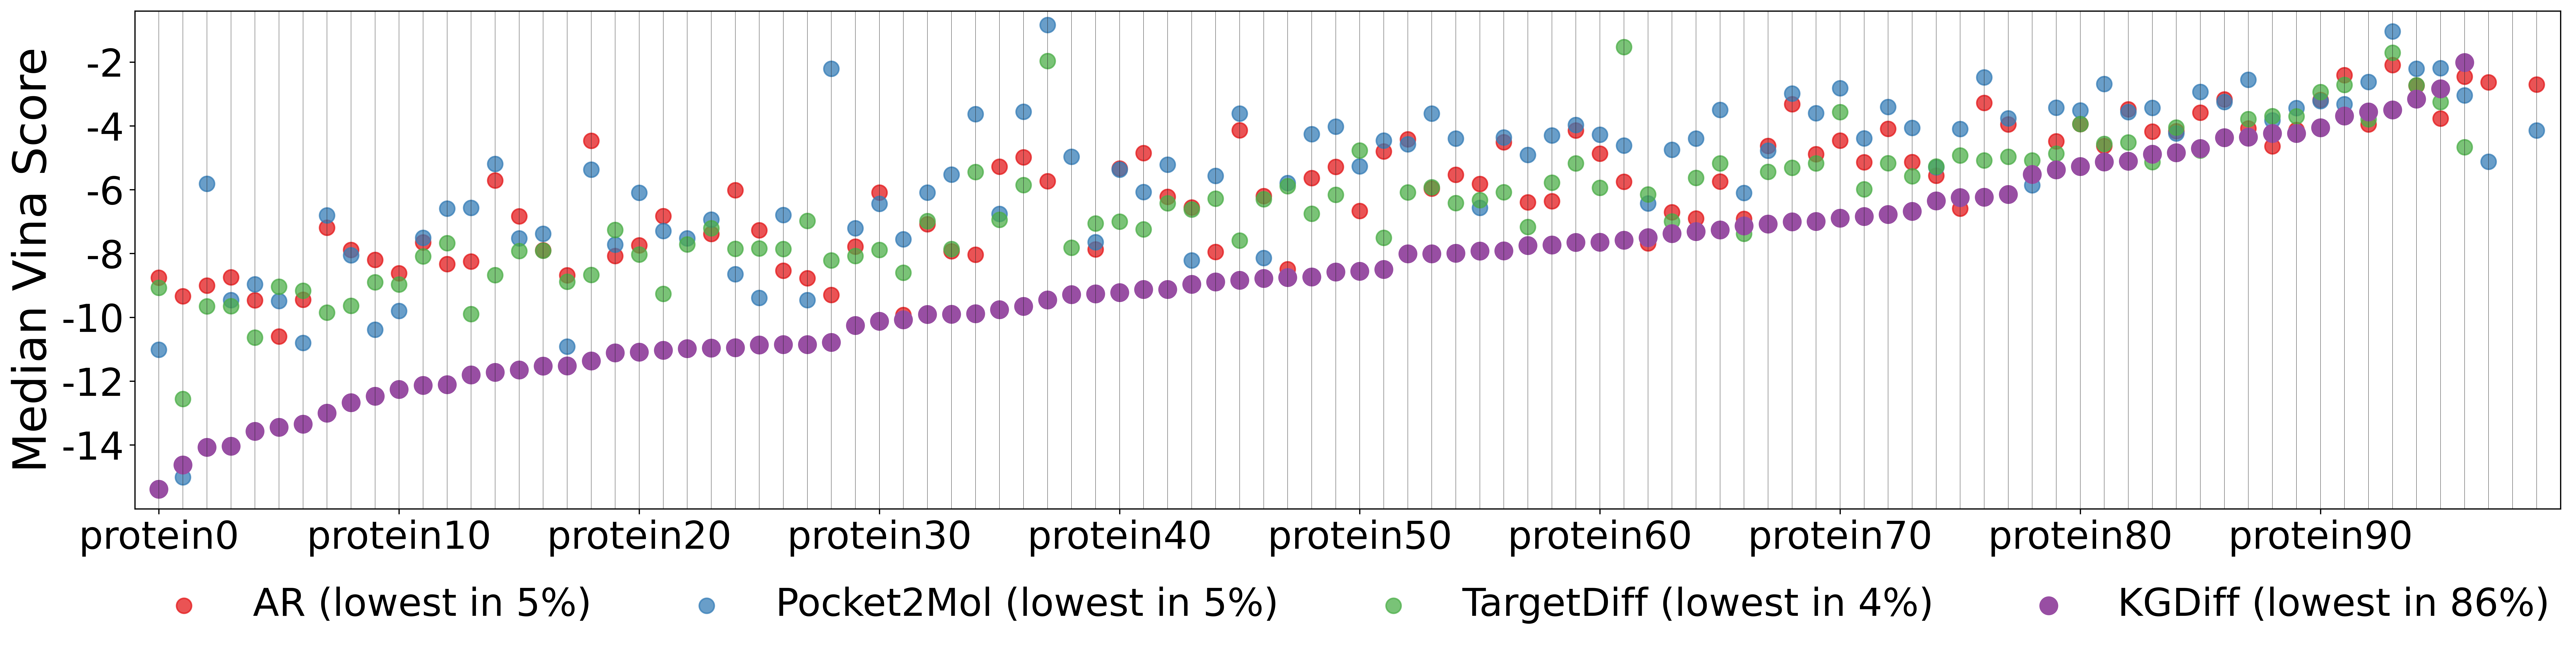

In [35]:
%config InlineBackend.figure_format = "retina"
plt.figure(figsize=(25, 6), dpi=300)

ax = plt.subplot(1, 1, 1)
ax.set_prop_cycle('color', plt.cm.Set1.colors)
n_data = len(our_vina)
fig1_idx = np.argsort(our_vina)
ALPHA = 0.75
POINT_SIZE = 128
plt.scatter(np.arange(n_data), ar_vina[fig1_idx], label=f'AR (lowest in {np.mean(best_vina_idx==1)*100:.0f}%)', alpha=ALPHA, s=POINT_SIZE * 0.75)
plt.scatter(np.arange(n_data), pocket2mol_vina[fig1_idx], label=f'Pocket2Mol (lowest in {np.mean(best_vina_idx==2)*100:.0f}%)', alpha=ALPHA, s=POINT_SIZE * 0.75)
plt.scatter(np.arange(n_data), targetdiff_vina[fig1_idx], label=f'TargetDiff (lowest in {np.mean(best_vina_idx==0)*100:.0f}%)', alpha=ALPHA, s=POINT_SIZE * 0.75)
# plt.scatter(np.arange(n_data), ref[fig1_idx], label=f'Reference (lowest in {np.mean(best_vina_idx==4)*100:.0f}%)', alpha=ALPHA, s=POINT_SIZE * 0.75)
plt.scatter(np.arange(n_data), our_vina[fig1_idx], label=f'{MODEL_NAME} (lowest in {np.mean(best_vina_idx==3)*100:.0f}%)', alpha=1, s=POINT_SIZE)

# plt.xticks([])
plt.yticks(fontsize=16)
for i in range(n_data):
    plt.axvline(i, c='0.1', lw=0.2)
plt.xlim(-1, 100)
plt.ylim(-16, -.4)
# plt.yticks([-10, -8, -6, -4, -2], [-10, -8, -6, -4, '$\geq$-2'], fontsize=25)
plt.yticks([-14, -12, -10, -8, -6, -4, -2], [ -14, -12, -10, -8, -6, -4, -2], fontsize=25)
plt.ylabel('Median Vina Score', fontsize=30)
plt.legend(fontsize=25, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.3), frameon=False)
plt.xticks(np.arange(0, 100, 10), [f'protein{v}' for v in np.arange(0, 100, 10)], fontsize=25)

plt.tight_layout()
# plt.savefig('output_figures/binding.png')

plt.show()

In [40]:
import os
import sys
import argparse
import shutil
import numpy as np
import pandas as pd
import torch
import torch.utils.tensorboard
# import seaborn as sns
# sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy import stats
from torch.nn.utils import clip_grad_norm_
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose
from tqdm.auto import tqdm
import sys
sys.path.append(os.path.abspath('./'))
import utils.misc as misc
import utils.train as utils_train
import utils.transforms as trans

from datasets import get_dataset
from datasets.pl_data import FOLLOW_BATCH
from models.molopt_score_model import ScorePosNet3D
config = misc.load_config('./configs/training.yml')
# Transforms
protein_featurizer = trans.FeaturizeProteinAtom()
ligand_featurizer = trans.FeaturizeLigandAtom(config.data.transform.ligand_atom_mode)
transform_list = [
    protein_featurizer,
    ligand_featurizer,
    trans.FeaturizeLigandBond(),
    trans.NormalizeVina(config.data.name)
]

transform = Compose(transform_list)

# Datasets and loaders
dataset, subsets = get_dataset(
    config=config.data,
    transform=transform,
)
train_set, val_set = subsets['train'], subsets['test']
# follow_batch = ['protein_element', 'ligand_element']
collate_exclude_keys = ['ligand_nbh_list']
# train_iterator = utils_train.inf_iterator(DataLoader(
#     train_set,
#     batch_size=config.train.batch_size,
#     shuffle=True,
#     num_workers=config.train.num_workers,
#     follow_batch=FOLLOW_BATCH,
#     exclude_keys=collate_exclude_keys
# ))
train_loader = DataLoader(train_set, 1, shuffle=True,
                        follow_batch=FOLLOW_BATCH, exclude_keys=collate_exclude_keys)
val_loader = DataLoader(val_set, 1, shuffle=False,
                        follow_batch=FOLLOW_BATCH, exclude_keys=collate_exclude_keys)

In [41]:
data_all = []
thred = torch.arange(.5,12,.5)
for protein_idx, data in tqdm(enumerate(val_loader), total=len(val_loader)):
    pro_coords = data['protein_pos']
    res_all = Globals.our_results[protein_idx]
    for molecule_idx, res in enumerate(res_all):
        mol = res['mol']
        atom_exp = res['atom_exp']
        exp = res['pred_exp']
        mol_coords = torch.tensor([list(mol.GetConformer().GetAtomPosition(atom.GetIdx())) for atom in mol.GetAtoms()])
        num_atoms = mol_coords.shape[0]
        num_thred = thred.shape[0]
        dist = torch.sum((mol_coords[:,None,:] - pro_coords[None,:,:])**2,dim=-1).sqrt()
        dis_dis = torch.sum((dist[:,:,None] - thred[None,None,:])<0, dim=1).view(-1)
#         pred = torch.tensor([atom_exp[atom.GetIdx()] for atom in mol.GetAtoms()]) - exp
        pred = torch.tensor([atom_exp[atom.GetIdx()] for atom in mol.GetAtoms()])
#         pred = torch.tensor([exp for atom in mol.GetAtoms()])
        pred = pred[:,None].repeat(1,num_thred).view(-1)
        atom_idx = torch.tensor([atom.GetIdx() for atom in mol.GetAtoms()])
        atom_idx = atom_idx.repeat(1,num_thred).view(-1)
        
        thred_flat = thred.repeat(num_atoms)
        # res_ = list(zip(dis_dis, pred[:,None].repeat(1,dis_dis.shape[-1])))
        d3_turple = torch.stack((
            dis_dis,
            pred,
            thred_flat,
            atom_idx,
            torch.tensor([molecule_idx]*len(atom_idx)),
            torch.tensor([protein_idx]*len(atom_idx)),
            torch.tensor([exp]*len(atom_idx)),
        ),dim=1)
        data_all.append(d3_turple)
        
data = torch.cat(data_all,dim=0)

  0%|          | 0/100 [00:00<?, ?it/s]

In [44]:
%config InlineBackend.figure_format = "retina"


thred = torch.arange(0.5,8.1,.5)
for ax, t in tqdm(zip(axes.flat, thred), total=len(thred)):
    
    max_num = data[data[:,2] == t][:,0].max().int()
    box_data_all_mean = []
    box_data_all_std = []
    box_data_all_num = []
    axis_arr = []
    for i in range(max_num):
        filt_data = data[torch.logical_and(data[:,2] == t , data[:,0]==i)][:,1]
        if len(filt_data) > 50:
            box_data_all_mean.append(torch.mean(filt_data))
            box_data_all_std.append(torch.std(filt_data))
            box_data_all_num.append(len(filt_data))
            axis_arr.append(i)


  0%|          | 0/16 [00:00<?, ?it/s]

In [45]:
def plot_with_var(reward_mean, reward_std, num_atoms=[], xaxis=[]):
    plt.figure(figsize=(8, 4), dpi=300)
    ax = plt.subplot(1, 1, 1)
    
    reward_mean = np.array(reward_mean)
    reward_std = np.array(reward_std)
#     num_atoms = np.array(num_atoms)
    """plot_with_variance
        reward_mean: typr list, containing all the means of reward summmary scalars collected during training
        reward_std: type list, containing all variance
        savefig_dir: if not None, this must be a str representing the directory to save the figure
    """
    half_reward_std = reward_std / 2.0
    lower = [x - y for x, y in zip(reward_mean, half_reward_std)]
    upper = [x + y for x, y in zip(reward_mean, half_reward_std)]
    
#     num_atoms = num_atoms / num_atoms.sum()
#     half_num_atoms = num_atoms / 2.0
#     lower_num = [x - y for x, y in zip(reward_mean, half_num_atoms)]
#     upper_num = [x + y for x, y in zip(reward_mean, half_num_atoms)]
    if len(xaxis) == 0:
        xaxis = list(range(len(lower)))
    
    #     xaxis = list([i/(t.item()**3) for i in range(len(lower))])
#     plt.title(f'thred = {t}')
    plt.plot(xaxis, reward_mean)
    plt.fill_between(xaxis, lower, upper, alpha=0.2)
#     plt.fill_between(xaxis, lower_num, upper_num, alpha=0.4)
    
#     plt.bar(xaxis, num_atoms*2, bottom=.1)
    
    # 启用较小的刻度
#     plt.minorticks_on()
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

    # 设置较小刻度的样式（不显示刻度值）
#     plt.tick_params(which='minor', length=2,direction='out')

    plt.grid(False)
    for i in range(len(reward_mean)):
        if i % 10 == 0:
            plt.axvline(i, c='0.1', lw=0.2)
#     plt.axhline(0, c='0.1', lw=.6, linestyle='dashed')
#     plt.axvline(64, c='0.1', lw=.6, linestyle='dashed')
    
    # 获取当前图形对象
    fig = plt.gcf()
    
    plt.xlim(0, 120)
#     plt.ylim(-0.35, 0.2)
    plt.ylim(0, 1)
    
#     ax.set_prop_cycle('color', plt.cm.Set1.colors)
    
    # 设置横轴标题字体大小
    plt.xlabel('number of surrounding protein atoms', fontsize=12)

    # 设置纵轴标题字体大小
    plt.ylabel('ligand atom score', fontsize=12)
    
    # 设置横轴字体大小
    plt.xticks(fontsize=8)

    # 设置纵轴字体大小
    plt.yticks(fontsize=8)
    
#     plt.legend(legend,prop={'size':8}, loc=4)

    # 显示图形
    plt.show()




In [46]:
abso_box_data_all_mean = copy.deepcopy(box_data_all_mean)
abso_box_data_all_std = copy.deepcopy(box_data_all_std)

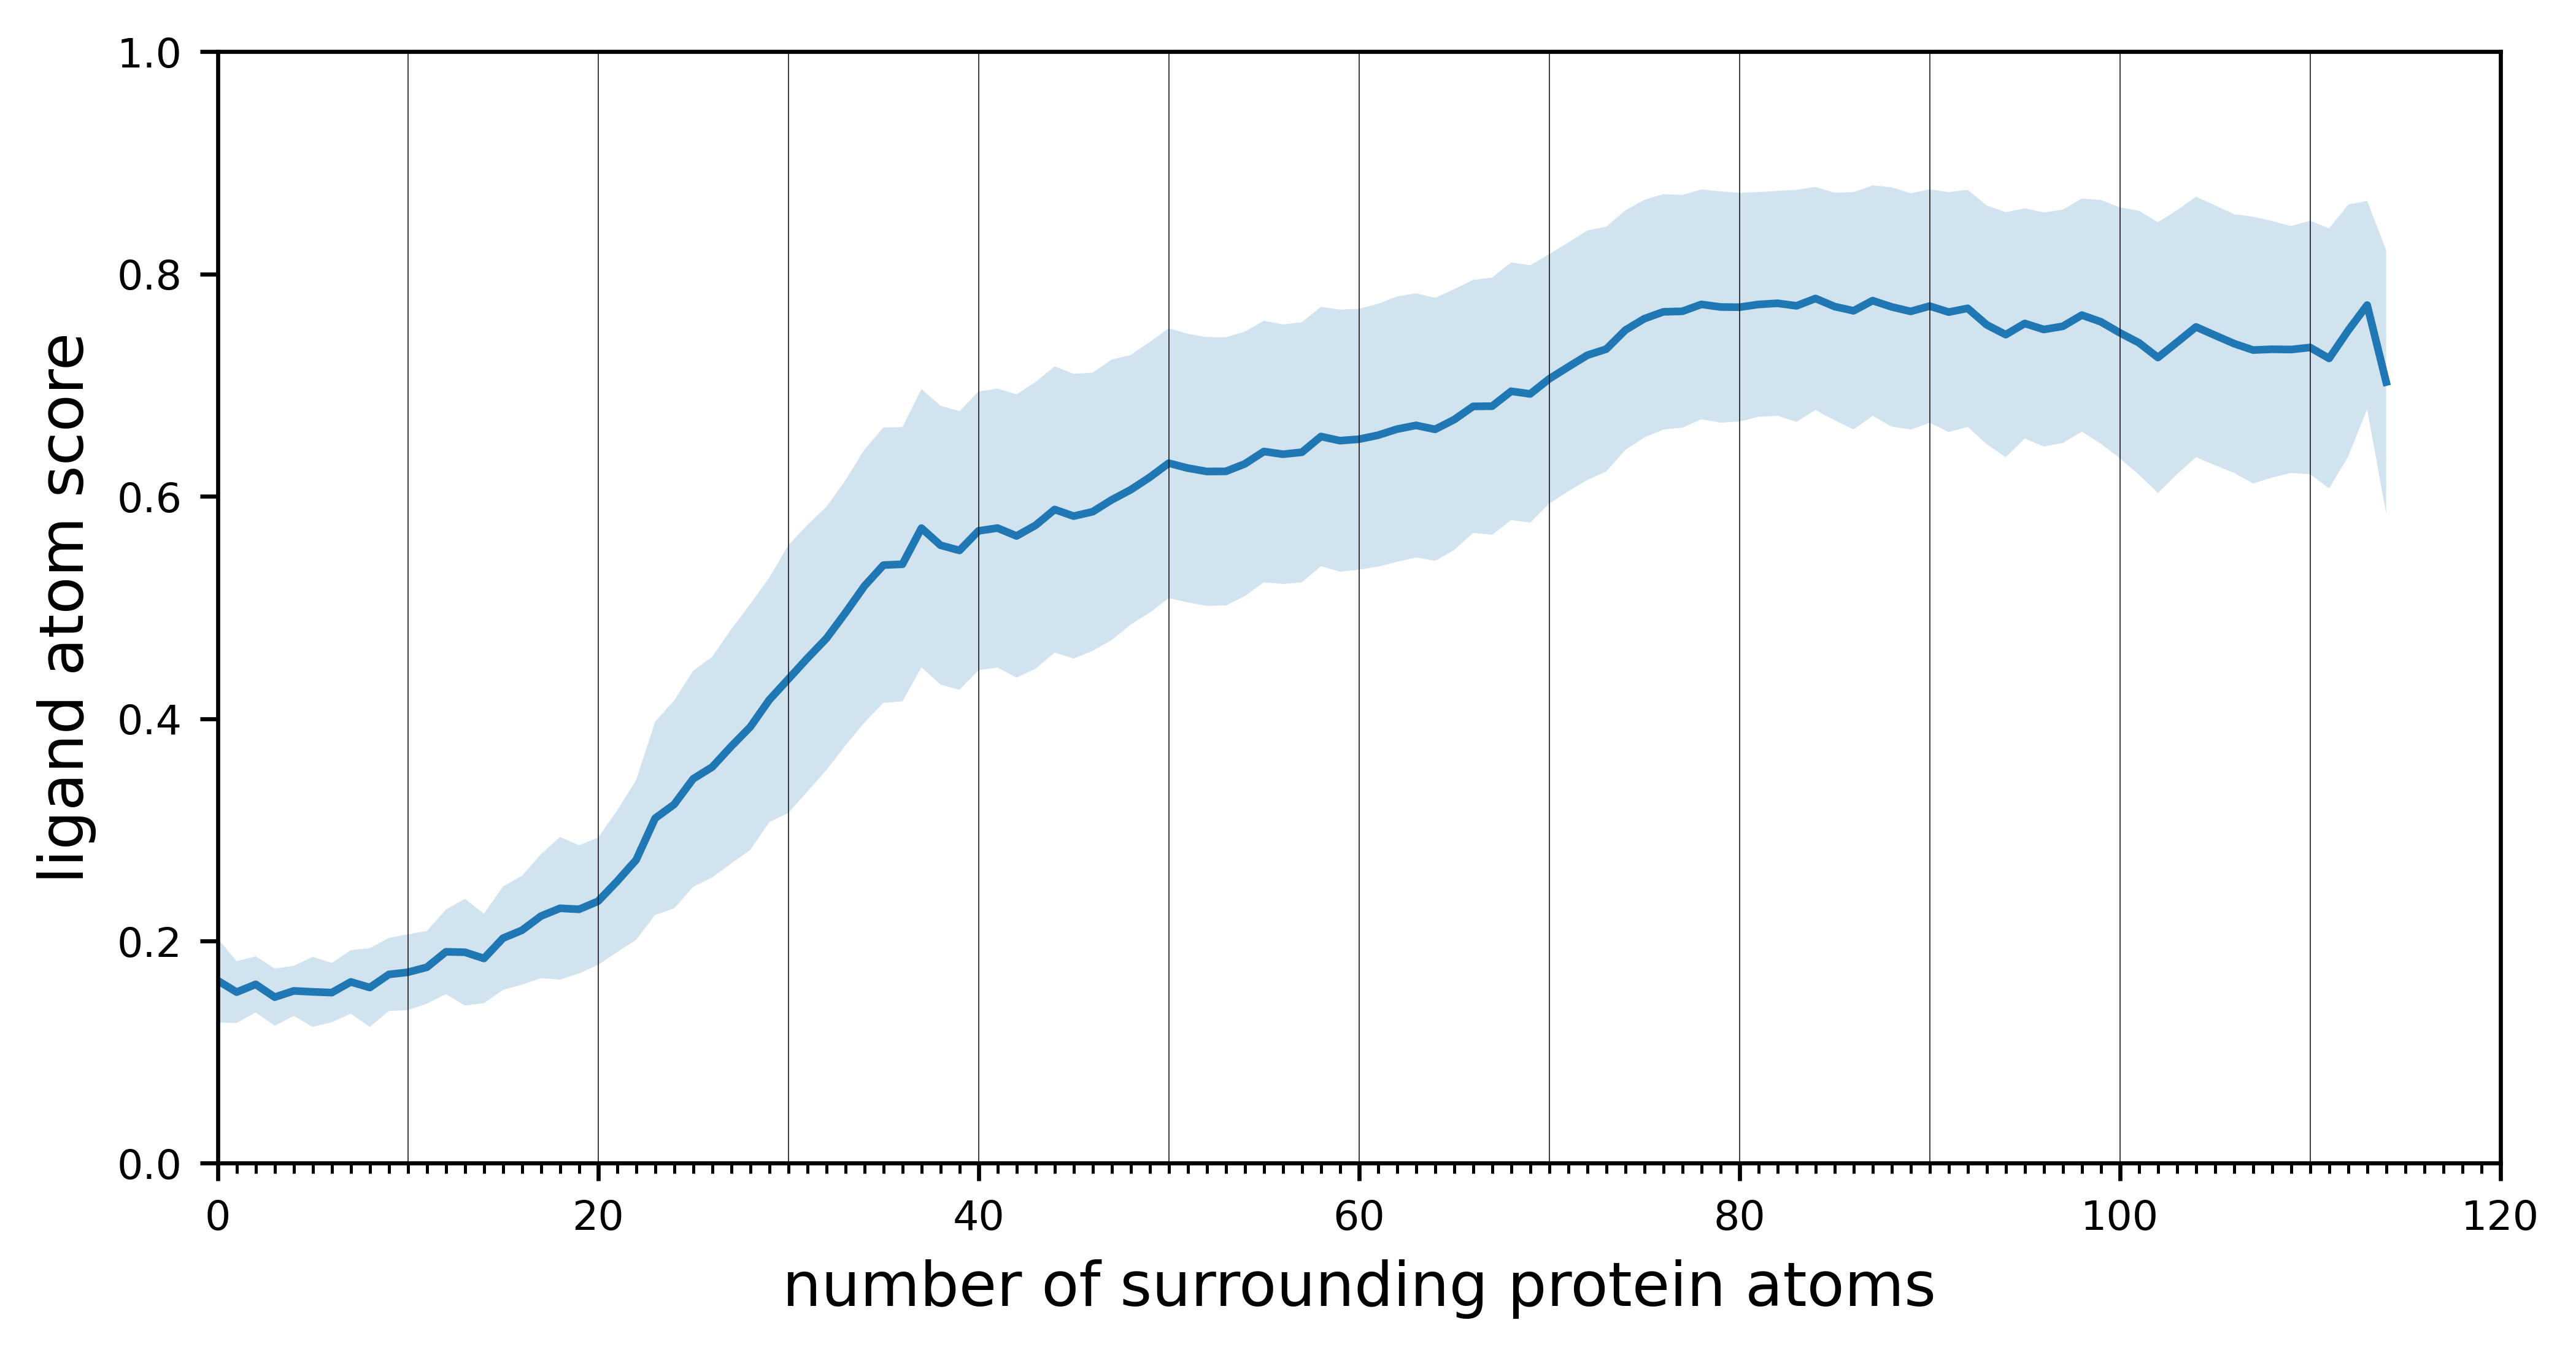

In [47]:
plot_with_var(abso_box_data_all_mean, abso_box_data_all_std)

In [93]:
import glob

def extract_traj(path):
    score_traj_pts = glob.glob(path)
    all_exp_traj = [torch.load(d)['pred_exp_traj'].T.reshape(-1,1000) for d in score_traj_pts]
    all_exp_traj_cat = np.concatenate(all_exp_traj,axis=0)
    return all_exp_traj_cat

def plot_with_var(data,legend=[]):
    plt.figure(figsize=(8, 4), dpi=300)
    ax = plt.subplot(1, 1, 1)
    """plot_with_variance
        reward_mean: typr list, containing all the means of reward summmary scalars collected during training
        reward_std: type list, containing all variance
        savefig_dir: if not None, this must be a str representing the directory to save the figure
    """
    xaxis = list(range(1000))
    
    for reward in data:
        reward_mean = np.mean(reward,axis=0)
        reward_std = np.std(reward,axis=0)
        half_reward_std = reward_std / 2.0
        lower = [x - y for x, y in zip(reward_mean, half_reward_std)]
        upper = [x + y for x, y in zip(reward_mean, half_reward_std)]
        plt.plot(xaxis, reward_mean)
        plt.fill_between(xaxis, lower, upper, alpha=0.2)
    
    ax.xaxis.set_minor_locator(plt.MultipleLocator(20))

    plt.grid(False)
    for i in range(len(reward_mean)):
        if i % 20 == 0:
            plt.axvline(i, c='0.1', lw=0.2)
#     plt.axhline(0, c='0.1', lw=.6, linestyle='dashed')
#     plt.axvline(64, c='0.1', lw=.6, linestyle='dashed')
    
    fig = plt.gcf()
    
    plt.xlim(-20, 1000)
    plt.ylim(0.2, .8)
    
#     ax.set_prop_cycle('color', plt.cm.Set1.colors)
    
    plt.xlabel('diffusion time steps', fontsize=12)

    plt.ylabel('predict score', fontsize=12)
    
    plt.xticks(fontsize=8)

    plt.yticks(fontsize=8)
    
    plt.legend(legend,prop={'size':8}, loc=4)
    plt.show()
    


In [94]:
sc_diff = torch.load('./misc_results/score_across_diffusion.pt')

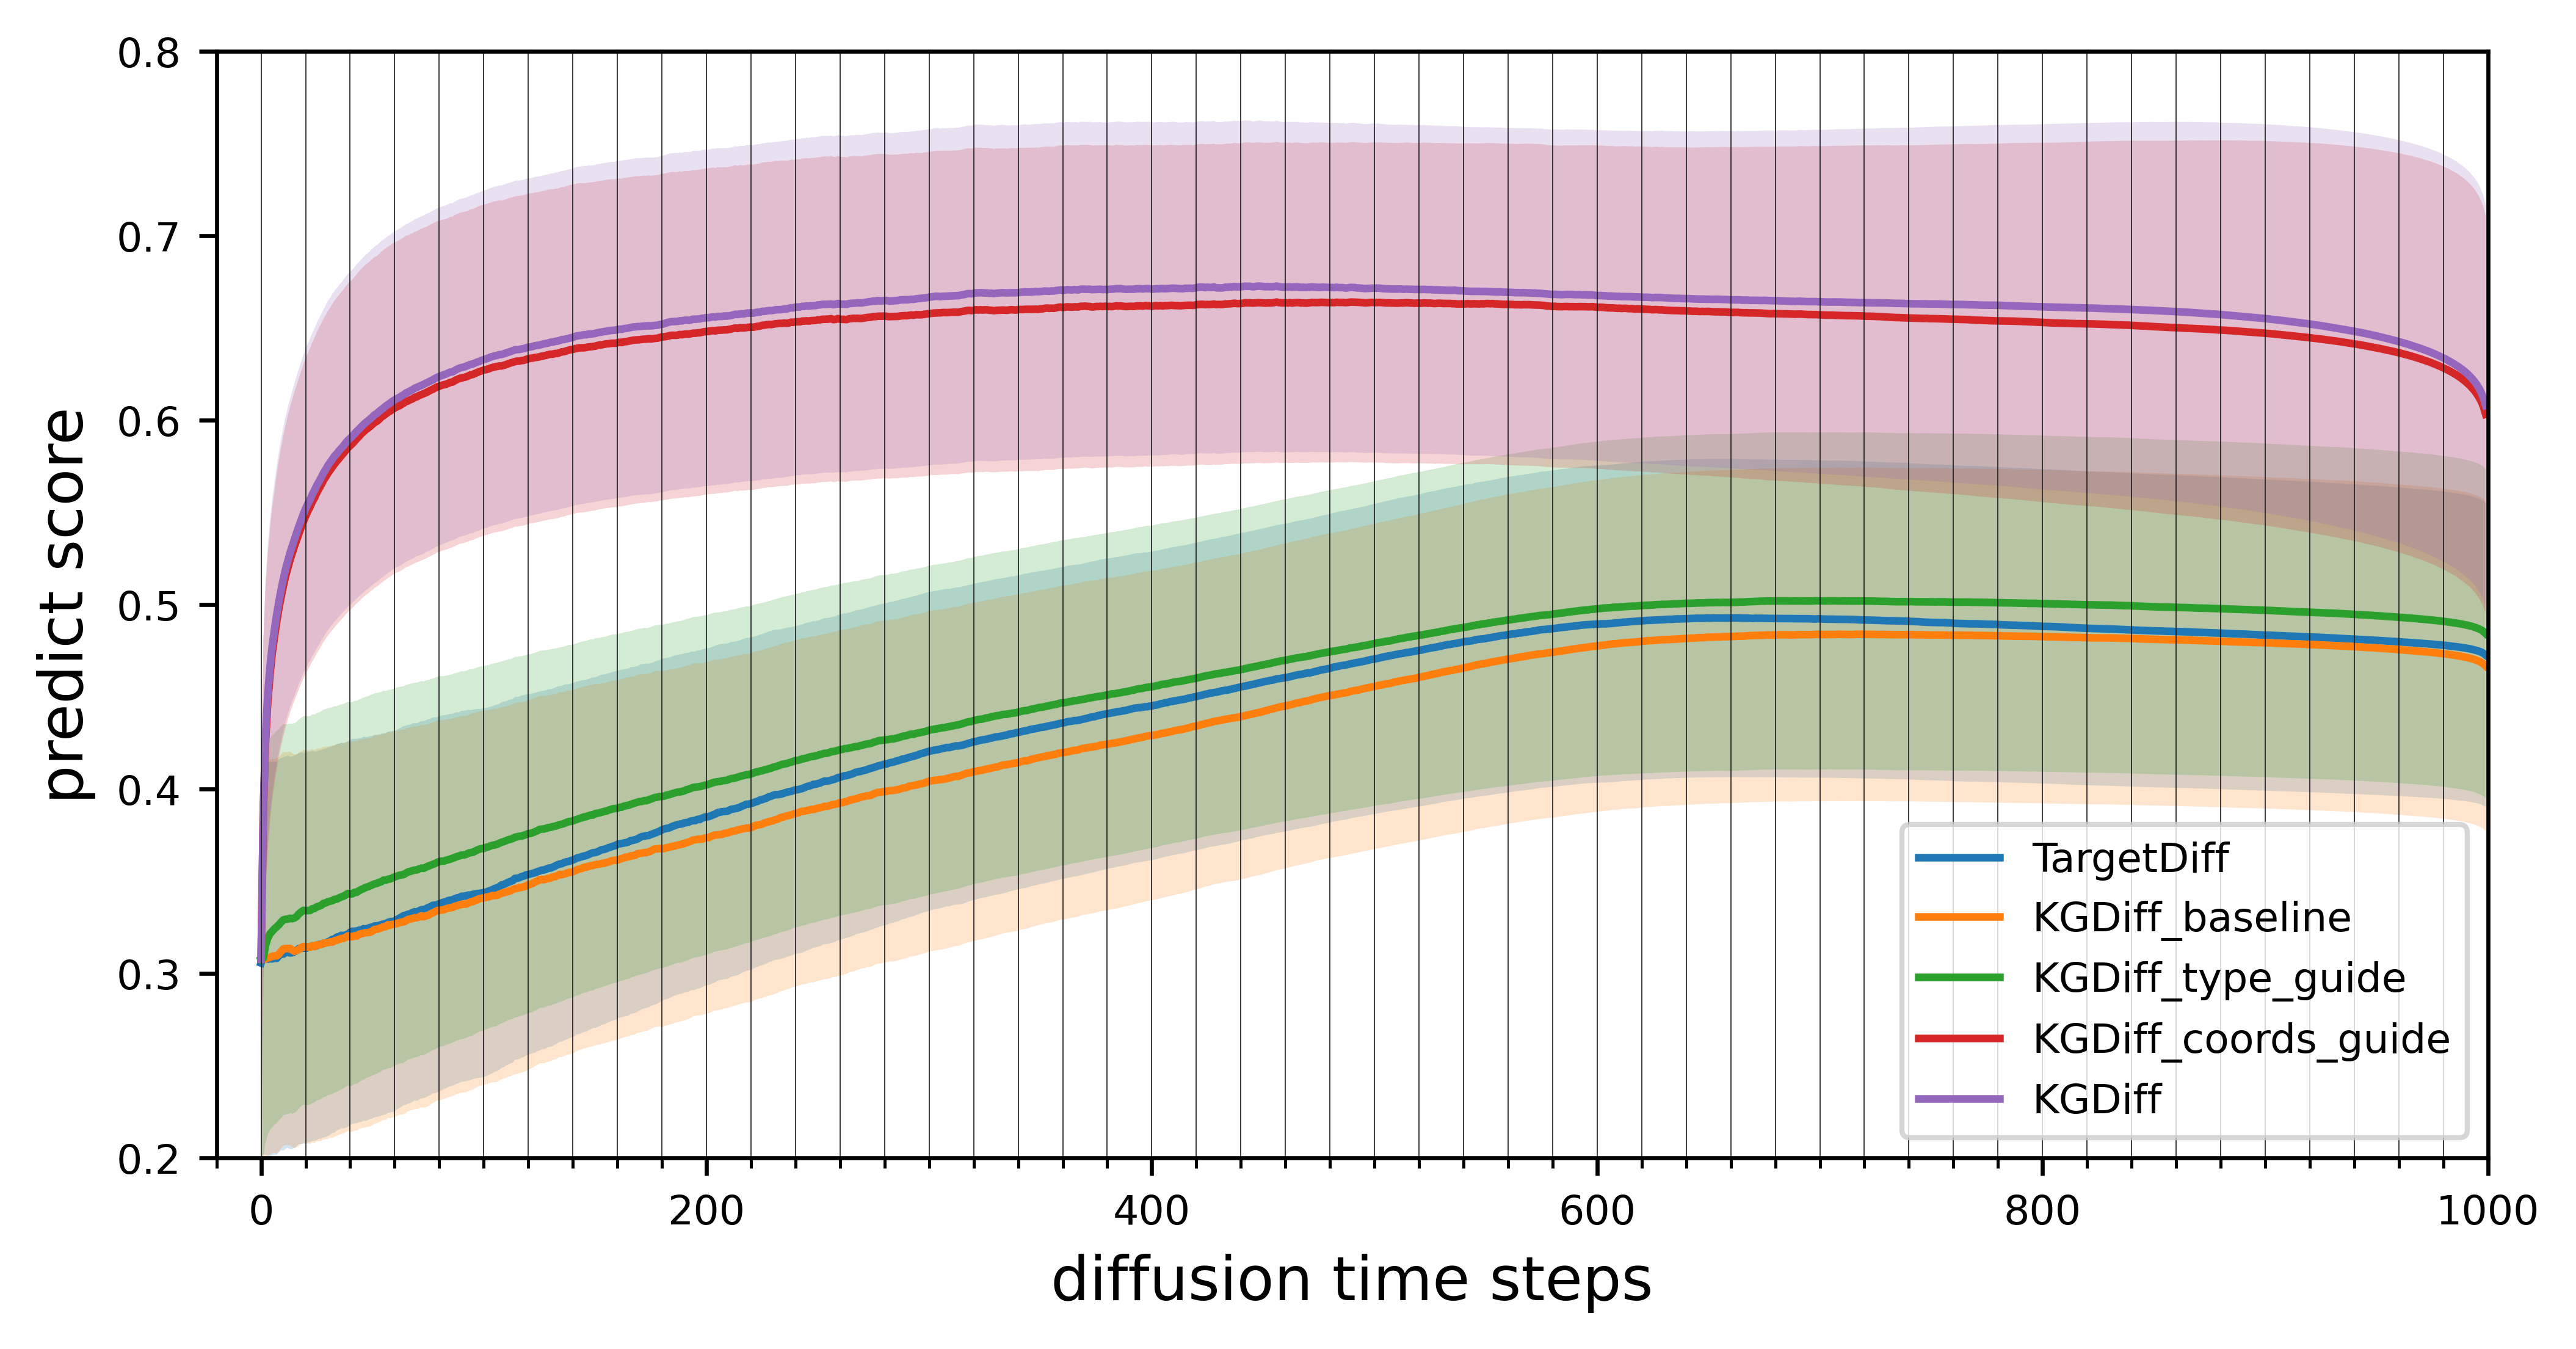

In [95]:
plot_with_var(sc_diff['benchmark'], legend=sc_diff['legend'])

In [55]:
from scipy import stats
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
import os
import qgrid
from scipy import stats
import seaborn as sns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)


def get_pearsonr(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return stats.pearsonr(y_true, y_pred)

def draw_pcc(pred_gt_aff_path):
    data=pd.read_csv(pred_gt_aff_path)

    exp_pearsonr = get_pearsonr(data['predict'], data['ground truth'])

    plot = sns.lmplot(data=data, x='predict', y='ground truth')

    plot.figure.set_dpi(300)

    # 获取当前图形对象
    fig = plt.gcf()

    # 设置图形大小
    fig.set_size_inches(8, 6)


    # 设置横轴字体大小
    plt.xticks(fontsize=12)

    # 设置纵轴字体大小
    plt.yticks(fontsize=12)

    # 设置横轴标题字体大小
    plt.xlabel('expert network', fontsize=16)

    # 设置纵轴标题字体大小
    plt.ylabel('ground truth', fontsize=16)

    # 显示图形
    plt.show()
    print(exp_pearsonr)

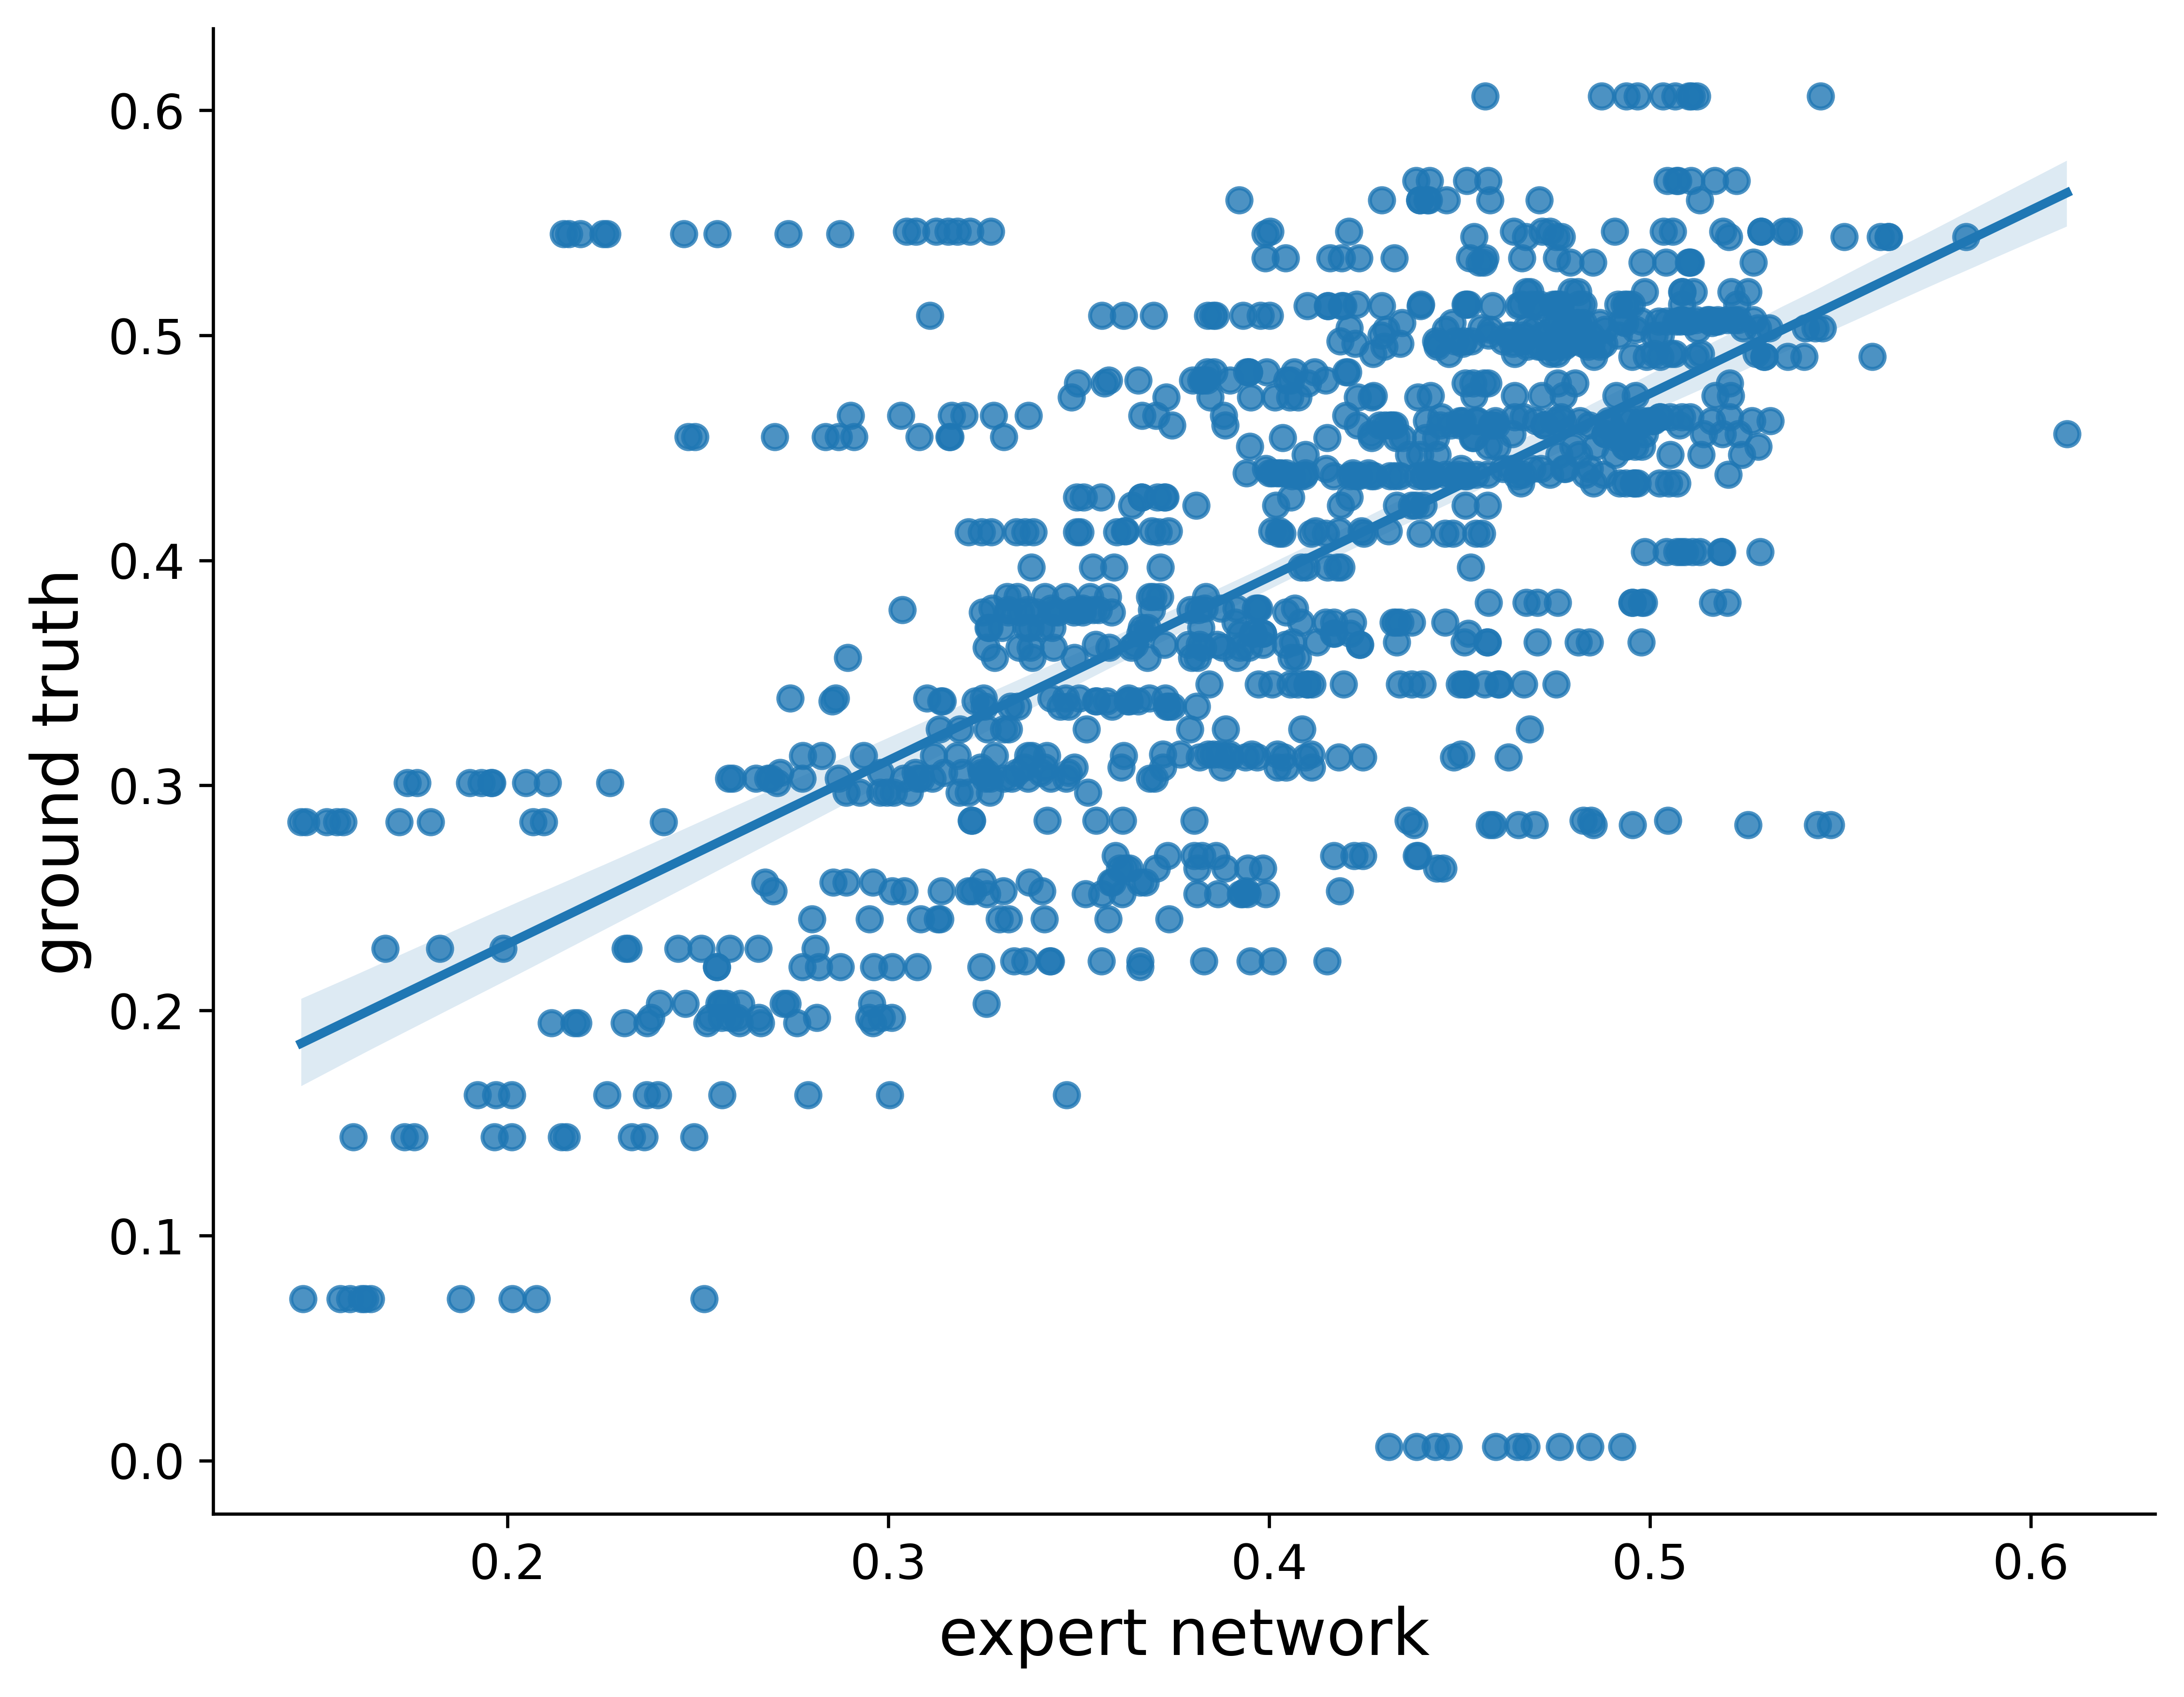

(0.6220724328649254, 3.6280109055742334e-108)


In [56]:
draw_pcc('./pred_aff_pdbbind_random_testset.csv')

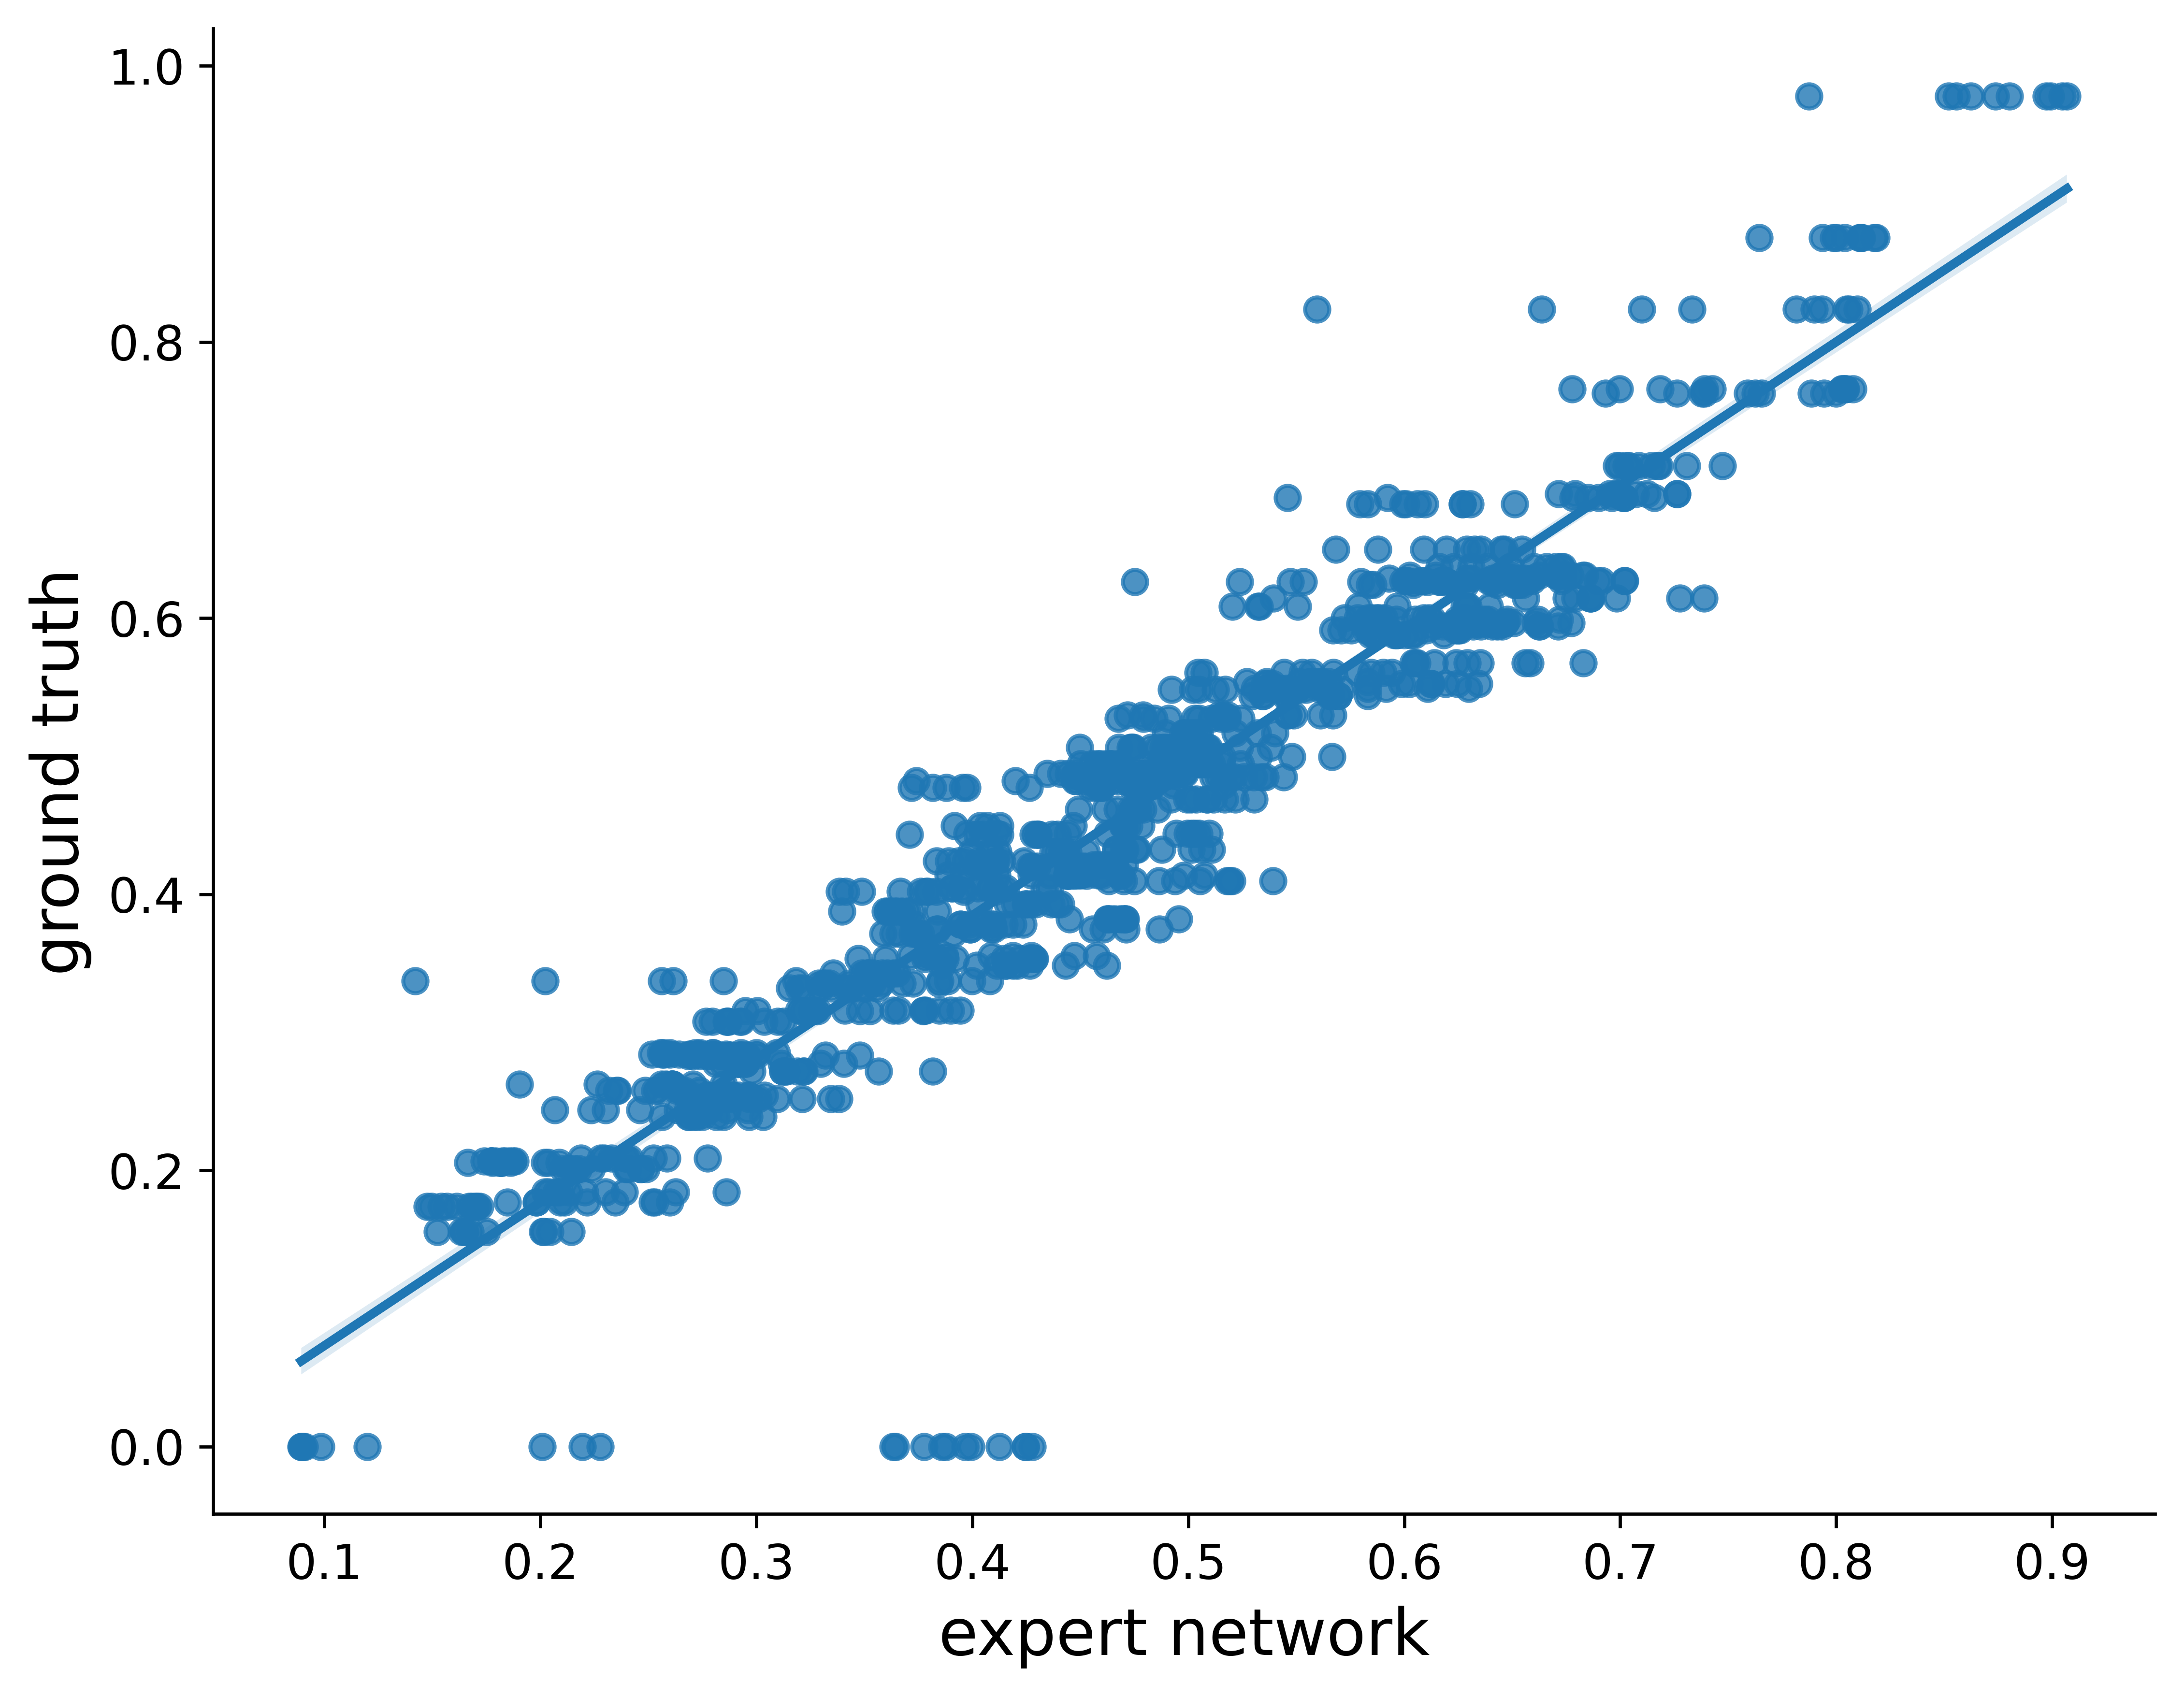

(0.9404246888430078, 0.0)


In [57]:
draw_pcc('./misc_results/pred_aff_crossdock.csv')

# pocket analysis

In [80]:
%config InlineBackend.figure_format = "retina"

def compute_volume(pos):
    x_max, x_min, y_max, y_min, z_max, z_min = max(pos[:,0]), min(pos[:,0]), max(pos[:,1]), min(pos[:,1]), max(pos[:,2]), min(pos[:,2]),
    return ((x_max-x_min)*(y_max-y_min)*(z_max-z_min)).item()

def plot_pcc(x, y, x_name, y_name):
    plot = sns.lmplot(
        data=pd.DataFrame(zip(x, y), columns=[x_name, y_name]), 
        x=x_name, 
        y=y_name,
    )
    plot.figure.set_dpi(300)
    
#     for i in range(100):
#         plt.axvline(i, c='0.1', lw=0.2)
        
    fig = plt.gcf()
    fig.set_size_inches(8, 6)

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.xlabel(x_name, fontsize=12)
    plt.ylabel(y_name, fontsize=12)

    plt.show()
    

In [81]:
from datasets import get_dataset
import utils.misc as misc
import utils.transforms as trans
from torch_geometric.transforms import Compose

config = misc.load_config('./configs/training.yml')
# Transforms
protein_featurizer = trans.FeaturizeProteinAtom()
ligand_featurizer = trans.FeaturizeLigandAtom(config.data.transform.ligand_atom_mode)
transform_list = [
    protein_featurizer,
    ligand_featurizer,
    trans.NormalizeVina()
]
transform = Compose(transform_list)
# Load dataset
dataset, subsets = get_dataset(
    config=config.data,
    transform=transform
)

test_set = subsets['test']
pocket = [p[0]['ligand_filename'] for p in Globals.our_results]
lig_file = [p['ligand_filename'] for p in test_set]
assert lig_file == pocket
pocket_volume = np.array([compute_volume(p['ligand_pos']) for p in test_set])
median_ligand_atom_num = np.array([np.median([len(v['pred_pos']) for v in pocket]) for pocket in Globals.our_results])

In [82]:
z_scores = stats.zscore(our_vina)
abs_z_scores = np.abs(z_scores)
filtered_data = our_vina[(abs_z_scores < 3)]   
filtered_volume = pocket_volume[(abs_z_scores < 3)]
filtered_median_ligand_atom_num = median_ligand_atom_num[(abs_z_scores < 3)]

print('outliers: %s' % (np.where(abs_z_scores >= 3)))
res = stats.pearsonr(filtered_data, filtered_volume)
print('pcc between volume and vina: %f'% res[0])

res = stats.pearsonr(filtered_median_ligand_atom_num, filtered_volume)
print('pcc between volume and ligand_atom_num: %f'% res[0])

outliers: [61]
pcc between volume and vina: -0.544891
pcc between volume and ligand_atom_num: 0.726036


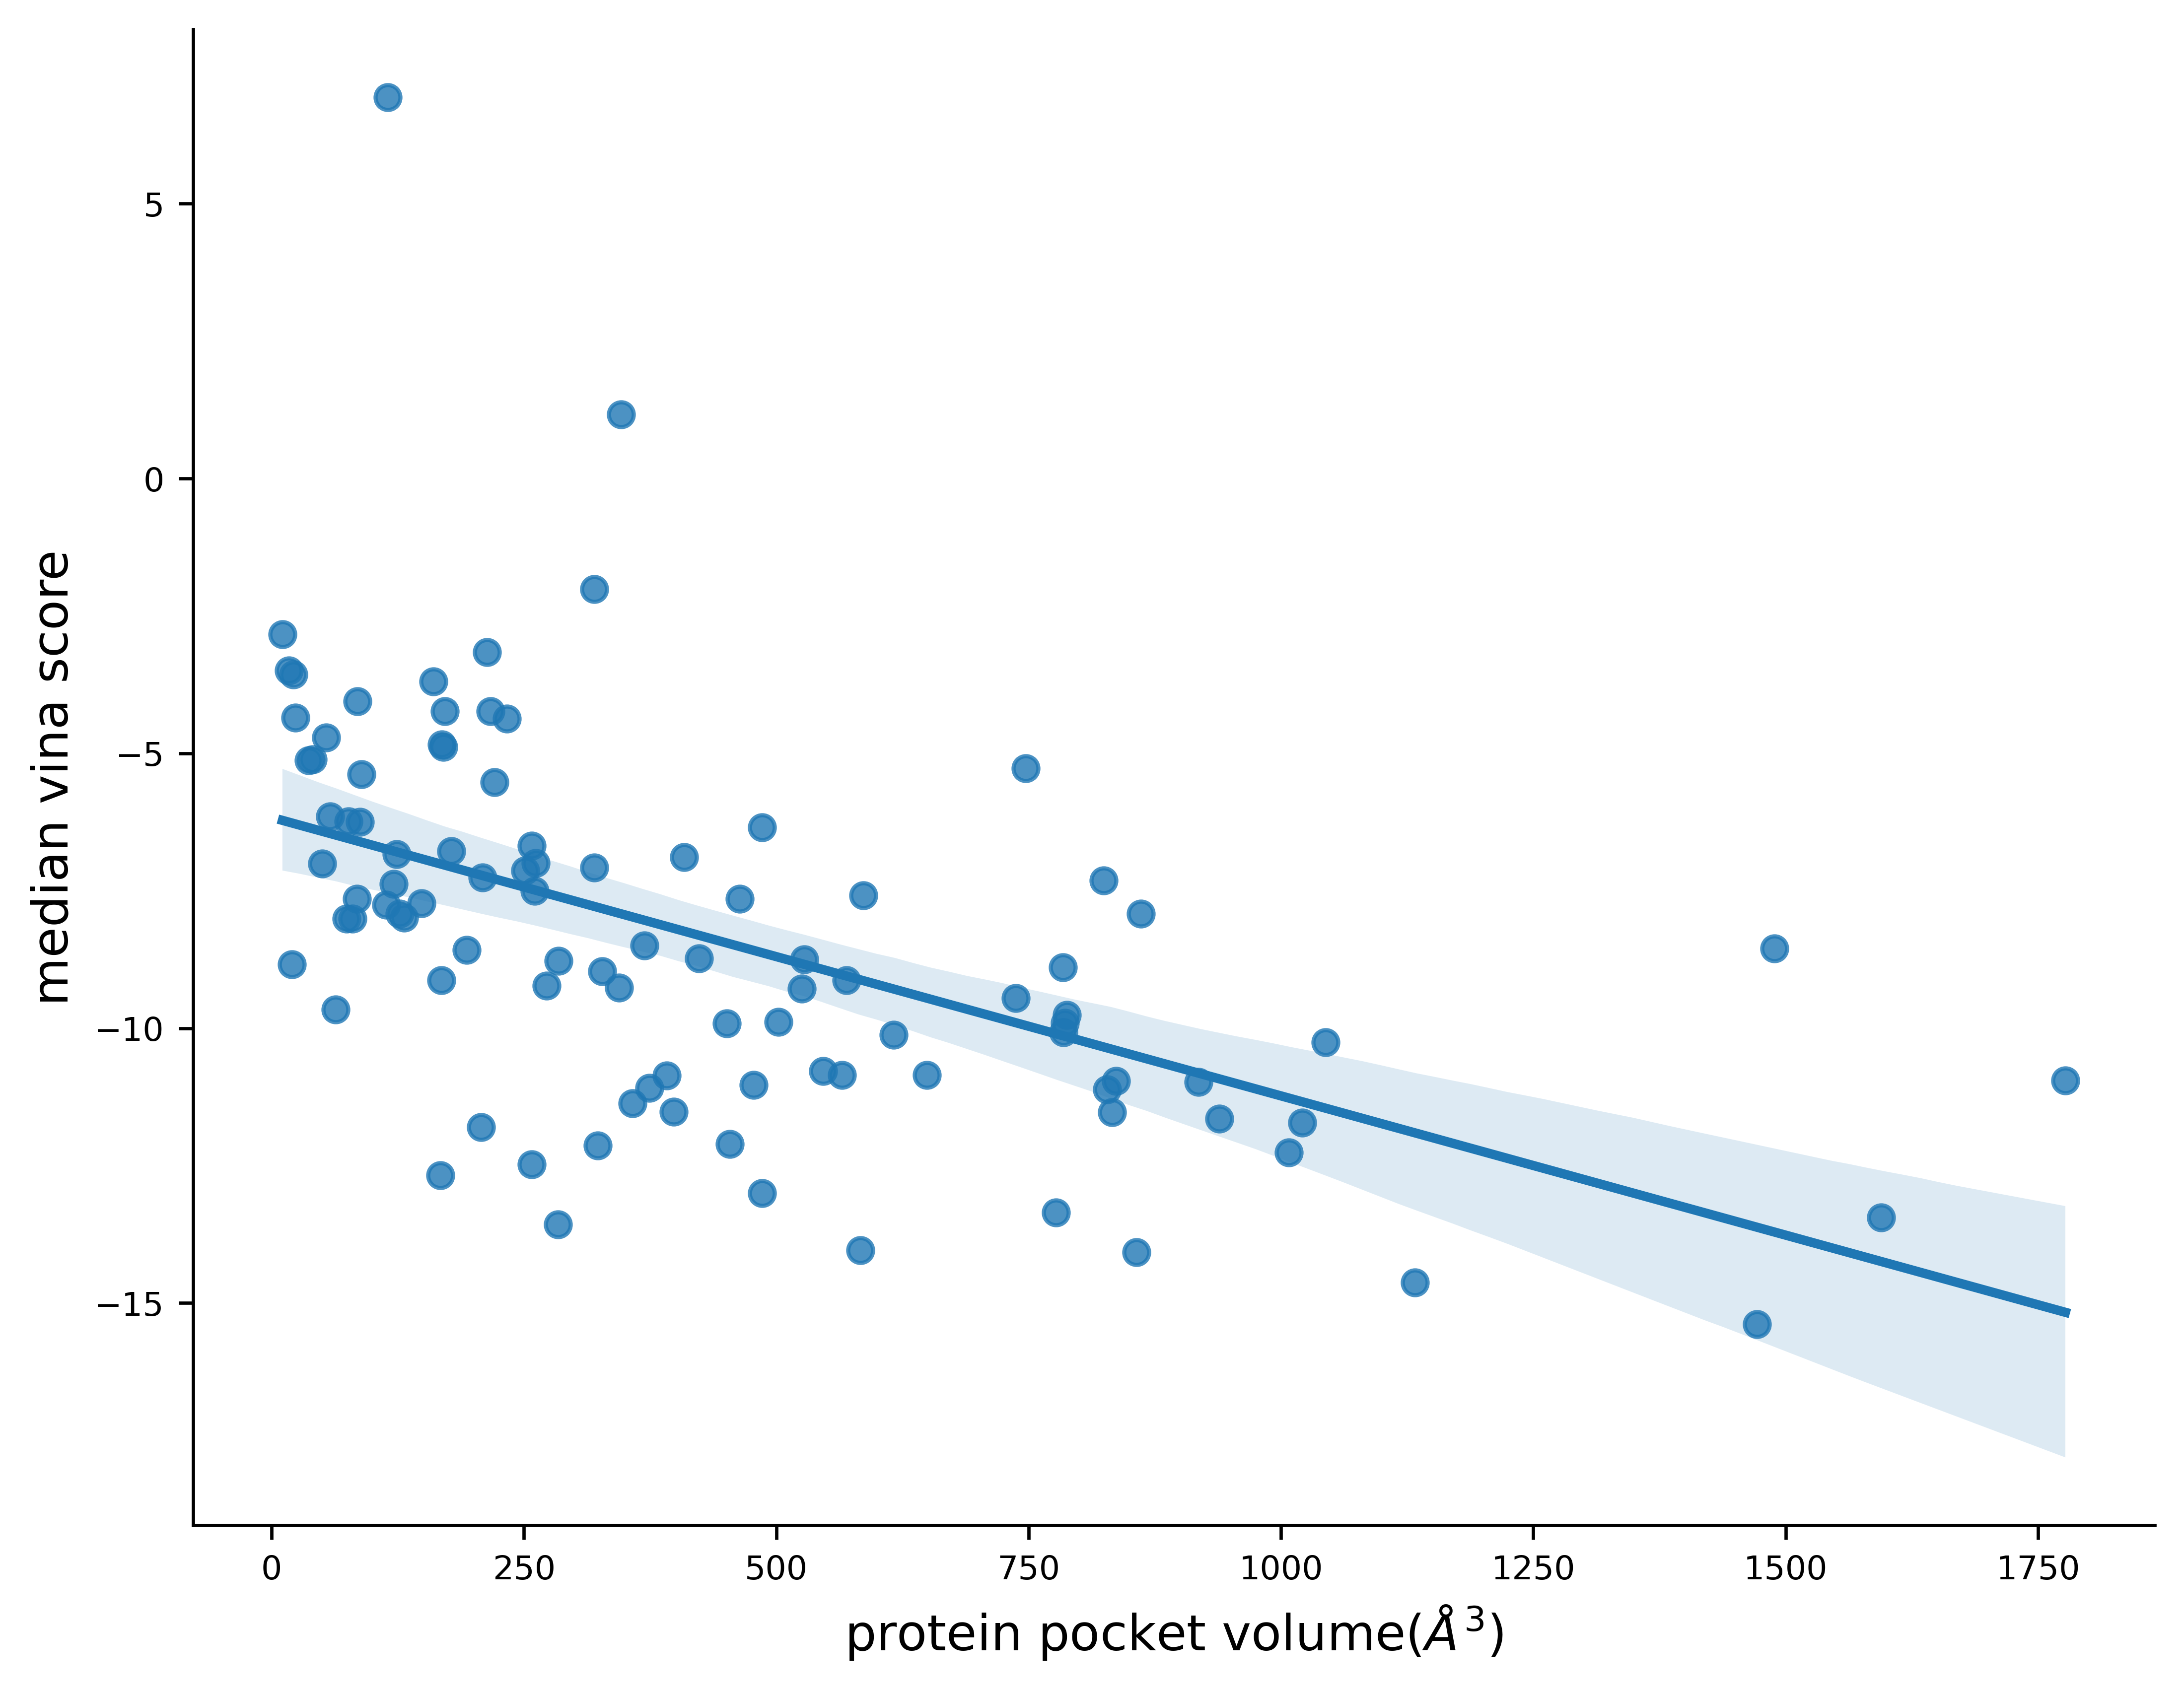

In [85]:
plot_pcc(filtered_volume, filtered_data, 'protein pocket volume($\AA^3$)', 'median vina score')